In [33]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt

In [34]:
X = np.load('../data/X.npy')
X = torch.tensor(X, dtype=torch.float32)
y = np.load('../data/y.npy')
y = torch.tensor(y, dtype=torch.float32)
X = X[y == 0]
X = (X - X.min()) / (X.max() - X.min())
X = X.reshape(-1, 1, 96)
X.shape

torch.Size([2069, 1, 96])

In [35]:
def auto_cov(X, lag=1):
    X = X - torch.mean(X, axis=2).unsqueeze(2)
    if lag == 0:
        return torch.sum(X * X, axis=2)
    else:
        return (X[:, :, lag:] * X[:, :, :-lag]).sum(axis=2)

def auto_corr(X, lag=1):
    return auto_cov(X, lag) / auto_cov(X, 0)
a = auto_corr(X).mean()
m = X.mean()
s = X.std()
a, m, s

(tensor(0.9690), tensor(0.3147), tensor(0.2253))

In [36]:
class ResidualBlock(nn.Module):
    def __init__(self, channels, kernel_size):
        super(ResidualBlock, self).__init__()
        self.conv_1 = nn.Conv1d(channels, channels, kernel_size, padding='same')
        self.conv_2 = nn.Conv1d(channels, channels, kernel_size, padding='same')
        self.batch_norm = nn.BatchNorm1d(channels)

    def forward(self, x):
        x_ = x
        x = F.relu(self.conv_1(x))
        x = self.conv_2(x)
        x = self.batch_norm(x)
        x = x + x_
        return x

class Generator(nn.Module):
    def __init__(self, channels):
        super(Generator, self).__init__()
        self.channels = channels
        self.res_blocks = nn.Sequential(*(9*[ResidualBlock(channels, 5), nn.ReLU()] + [ResidualBlock(channels, 5)]))

    def forward(self, x):
        x = F.sigmoid(self.res_blocks(x))
        return x[:, :, 48:-48]

class Discriminator(nn.Module):
    def __init__(self, channels):
        super(Discriminator, self).__init__()
        self.channels = channels
        self.pool = nn.MaxPool1d(2)
        self.conv1 = nn.Conv1d(channels, 8, 5, padding='same')
        self.conv2 = nn.Conv1d(8, 16, 5, padding='same')
        self.conv3 = nn.Conv1d(16, 32, 5, padding='same')
        self.conv4 = nn.Conv1d(32, 32, 5, padding='same')
        self.fc1 = nn.Linear(32*6, 64)
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = x.view(-1, 48)
        x = F.relu(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        return x

In [37]:
channels = 8
batch_size = 256
minibatch_size = 32

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
G = Generator(channels)
G.to(device)
D = Discriminator(channels)
D.to(device)

criterion = nn.BCELoss()
optimizer_G = optim.Adam(G.parameters(), lr=1e-5)
optimizer_D = optim.Adam(D.parameters(), lr=1e-5)

n_sub_epochs = [(20, 20)]*100
num_epochs = sum([sum(sub_epoch) for sub_epoch in n_sub_epochs])
epoch = 0
best_score = float('inf')
for sub_epoch in n_sub_epochs:
    for _ in range(sub_epoch[0]):
        for _ in range(batch_size):
            real_data = X[np.random.choice(X.shape[0], minibatch_size*channels, replace=False)].reshape(-1, channels, 96).to(device)
            optimizer_D.zero_grad()
            D_real = D(real_data)
            D_real_loss = criterion(D_real, torch.ones_like(D_real))
            
            fake_data = G(torch.randn(32, channels, 96*2, device=device))
            D_fake = D(fake_data.detach())
            D_fake_loss = criterion(D_fake, torch.zeros_like(D_fake))

            D_loss = D_real_loss + D_fake_loss
            D_loss.backward()
            optimizer_D.step()

        epoch += 1
        print(f"Epoch {epoch}/{num_epochs}, D Loss: {D_loss.item()}")

    for _ in range(sub_epoch[1]):
        for _ in range(batch_size):
            optimizer_G.zero_grad()
            fake_data = G(torch.randn(32, channels, 96*2, device=device))

            a_fake = auto_corr(fake_data.squeeze()).mean()
            G_stat_loss = torch.abs(a_fake - a)

            output = D(fake_data)
            G_disc_loss = criterion(output, torch.ones_like(output))

            G_loss = G_disc_loss + G_stat_loss
            G_loss.backward()
            optimizer_G.step()

        epoch += 1
        print(f"Epoch {epoch}/{num_epochs}, G Loss: {G_loss.item()}")

    print(f"a_fake: {a_fake}")
    score = (a_fake - a)**2
    if score < best_score:
        best_score = score
        best_G = G
        print(f"Best score: {score}")

Epoch 1/200, D Loss: 1.3815946578979492
Epoch 2/200, D Loss: 1.3599543571472168
Epoch 3/200, D Loss: 1.2981047630310059
Epoch 4/200, D Loss: 1.2125427722930908
Epoch 5/200, D Loss: 1.1160893440246582
Epoch 6/200, D Loss: 1.0155224800109863
Epoch 7/200, D Loss: 0.950891375541687
Epoch 8/200, D Loss: 0.8324676752090454
Epoch 9/200, D Loss: 0.7598134279251099
Epoch 10/200, D Loss: 0.6673673987388611
Epoch 11/200, G Loss: 3.5219106674194336
Epoch 12/200, G Loss: 2.9941518306732178
Epoch 13/200, G Loss: 2.537907600402832
Epoch 14/200, G Loss: 2.23801326751709
Epoch 15/200, G Loss: 2.050250768661499
Epoch 16/200, G Loss: 1.9870717525482178
Epoch 17/200, G Loss: 1.8948211669921875
Epoch 18/200, G Loss: 1.816469430923462
Epoch 19/200, G Loss: 1.783968210220337
Epoch 20/200, G Loss: 1.7075003385543823
a_fake: 0.8375611305236816
Best score: 0.017267774790525436
Epoch 21/200, D Loss: 0.6654951572418213
Epoch 22/200, D Loss: 0.6051726937294006
Epoch 23/200, D Loss: 0.49651283025741577
Epoch 24/200

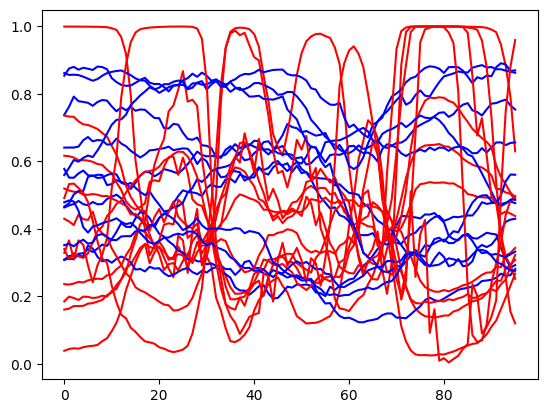

In [38]:
best_G.eval()
fake_data = best_G(torch.randn(2, channels, 96*2, device=device)).reshape(-1, 96).cpu()
for i in range(12):
    plt.plot(fake_data[i].detach().numpy(), color='red')
    plt.plot(X[i, 0].detach().numpy(), color='blue')
plt.show()

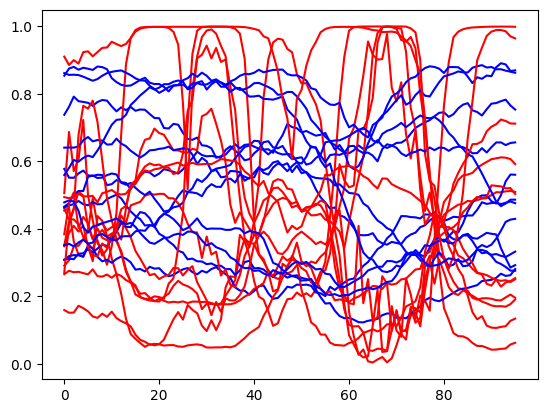

In [53]:
G.eval()
fake_data = G(torch.randn(2, channels, 96*2, device=device)).reshape(-1, 96).cpu()
for i in range(12):
    plt.plot(fake_data[i].detach().numpy(), color='red')
    plt.plot(X[i, 0].detach().numpy(), color='blue')
plt.show()